In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

confusion_matrix: 

# 加载数据

In [19]:
print( tf.__version__)

1.10.0


In [2]:
from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

In [3]:
print("Size of:")
print("- Training-set:\t\t{}".format(data.num_train))
print("- Validation-set:\t{}".format(data.num_val))
print("- Test-set:\t\t{}".format(data.num_test))

Size of:
- Training-set:		55000
- Validation-set:	5000
- Test-set:		10000


In [4]:
# The images are stored in one-dimensional arrays of this length.
img_size_flat = data.img_size_flat

# Tuple with height and width of images used to reshape arrays.
img_shape = data.img_shape

# Number of classes, one class for each of 10 digits.
num_classes = data.num_classes

# 数据处理

## One-hot编码

In [5]:
data.y_test[0:5, :]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [6]:
data.y_test_cls[0:5]

array([7, 2, 1, 0, 4])

## 绘制图像

In [7]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

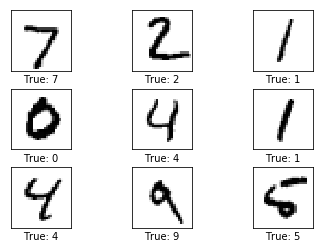

In [8]:
images = data.x_test[0:9]

cls_true = data.y_test_cls[0:9]

plot_images(images=images, cls_true=cls_true)

# Tensorflow图

包含信息：

1、图的输入：占位符变量 placeholder

2、模型变量：model 将会被优化，模型表现得更好

3、损失评估：cost度量指导变量的优化

4、优化方法：GD，更新模型的变量

## placeholder

作用：图的输入，每次运行图可能会改变

改变过程：feeding placeholder

类型：张量 —— 多维向量或矩阵

输入特征

In [9]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

输入标签One hot

In [10]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

真实标签 - placeholder变量

In [11]:
y_true_cls = tf.placeholder(tf.int64, [None])

## 需要优化的变量

初始化权重, 权重全部初始化为0

In [12]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

初始化偏差

In [13]:
biases = tf.Variable(tf.zeros([num_classes]))

## 模型


x(placeholder) * weight + biases

In [14]:
logits = tf.matmul(x, weights) + biases

softmax层：

由来：logits只表示第 i 行第 j 列的那个元素代表着第 i 张输入图像有多大可能性是第 j 个类别

效果：归一化，每个元素限制在0到1之间，每一行相加等于1

作用：多分类

In [15]:
y_pred = tf.nn.softmax(logits)

In [21]:
y_pred_cls = tf.arg_max(y_pred, dimension=1)

## 优化损失函数

损失函数：

交叉熵（cross-entropy），最小化交叉熵

In [22]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, 
                                                          labels=y_true)

所有图像分类交叉熵的均值

In [23]:
cost = tf.reduce_mean(cross_entropy)

## 优化方法

优化方法：梯度下降，步长=0.5

作用：往tensorflow图中添加优化器，以便之后的操作

In [24]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

## 性能度量

准确率ACC

In [25]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [26]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 运行Tensorflow

## 创建Tensorflow会话（session）

In [27]:
session = tf.Session()

## session 初始化所有变量

In [28]:
session.run(tf.global_variables_initializer())

## 优化迭代

问题：样本量有50000，太大，使用梯度下降花费较多时间

解决：采用 mini-batch 梯度下降的方法，在优化器的每次迭代中只用一小部分的图像

In [31]:
batch_size = 100

In [ ]:
def optimize(num_iterations):
    for i in 